In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import torch
import random
import datetime
import pandas as pd
import os
import seaborn as sns
import time
from calendar import monthrange, month_name
import xarray as xr
import rioxarray
from dateutil.relativedelta import relativedelta
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

import argparse

from utils import normalize

from mpnnlstm import NextFramePredictorS2S
from seq2seq import Seq2Seq

from torch.utils.data import Dataset, DataLoader

from ice_test import IceDataset
from utils import int_to_datetime

def masked_accuracy(mask):
    def loss(y_true, y_pred):
        y_true_masked = np.multiply(y_true, mask)
        y_pred_masked = np.multiply(y_pred, mask)
        return accuracy_score(y_true_masked, y_pred_masked)
    return loss

def masked_MSE(mask):
    def loss(y_true, y_pred):
        sq_diff = np.multiply((y_pred - y_true)**2, mask)
        return np.mean(sq_diff)
    return loss

def masked_RMSE(mask):
    def loss(y_true, y_pred):
        sq_diff = np.multiply((y_pred - y_true)**2, mask)
        return np.sqrt(np.mean(sq_diff))
    return loss

mask = np.isnan(xr.open_zarr('data/era5_hb_daily.zarr').siconc.isel(time=0)).values

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_dir = 'ice_results_gnn_out'

In [90]:
months = range(1, 13)
ds = []
for month in months:
    try:
        ds.append(xr.open_dataset(f'{results_dir}/valpredictions_M{month}_Y2011_Y2015_I5O30.nc', engine='netcdf4'))
    except Exception as e: #FileNotFoundError:
        print(e)
        pass
    
ds = xr.concat(ds, dim='launch_date')
ds = ds.rio.set_crs(4326)

[Errno 2] No such file or directory: b'/Users/zach/Documents/Quadtree-MPNNLSTM/ice_results_gnn_out/valpredictions_M6_Y2011_Y2015_I5O30.nc'


In [91]:
ds['launch_date'] = [int_to_datetime(dt) for dt in ds.launch_date.values]

In [92]:
months = range(1, 13)
losses = {}
for month in months:
    try:
        losses[month] = pd.read_csv(f'{results_dir}/loss_M{month}_Y2011_Y2015_I5O30.csv')
    except FileNotFoundError:
        pass

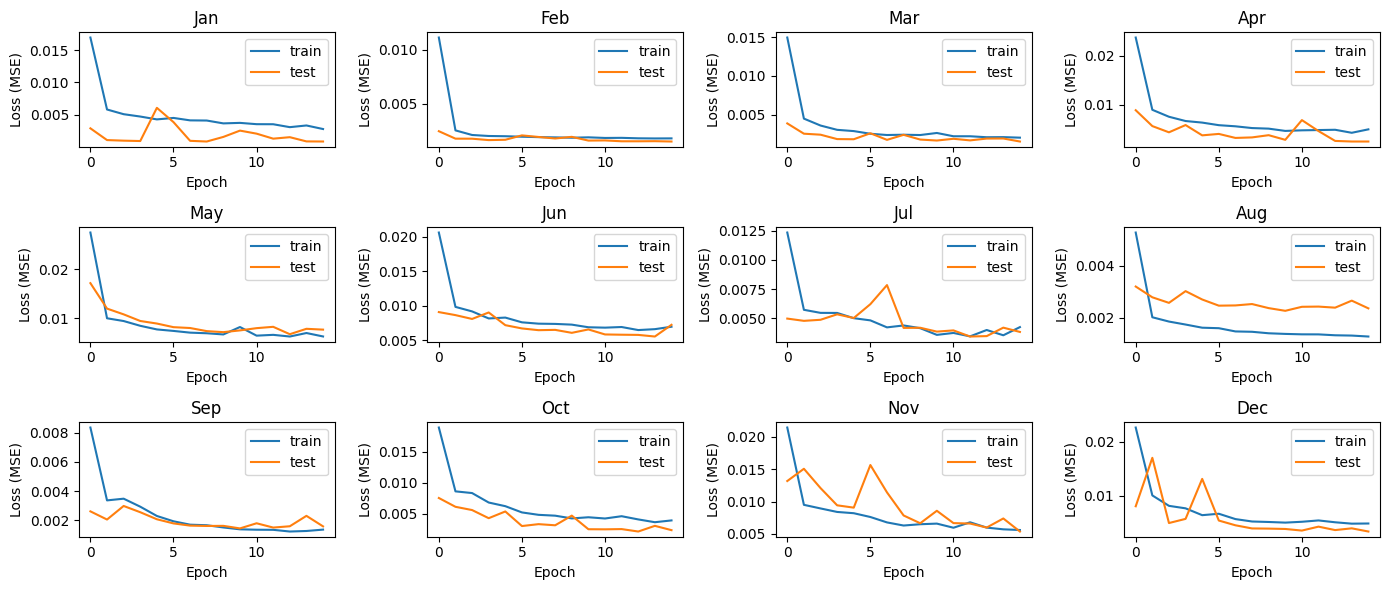

In [93]:
fig, axs = plt.subplots(3, 4, figsize=(14, 6))
for i, month in enumerate(months):
    try:
        axs.flatten()[i].plot(losses[month].train_loss, label='train')
        axs.flatten()[i].plot(losses[month].test_loss, label='test')
        axs.flatten()[i].legend()
        
        axs.flatten()[i].set_ylabel('Loss (MSE)')
        axs.flatten()[i].set_xlabel('Epoch')
        axs.flatten()[i].set_title(month_name[month][:3])
    except KeyError:
        pass
    
plt.tight_layout()

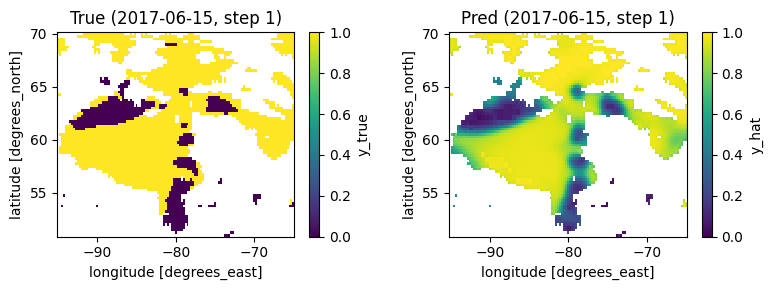

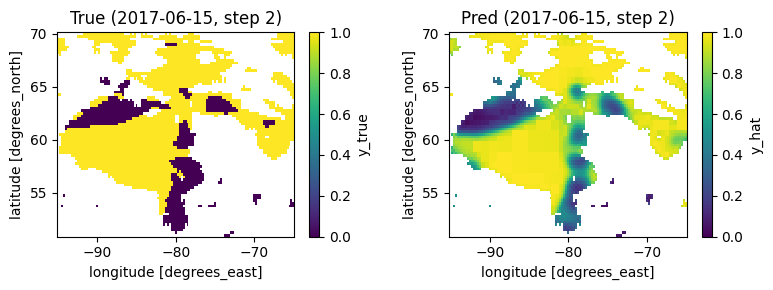

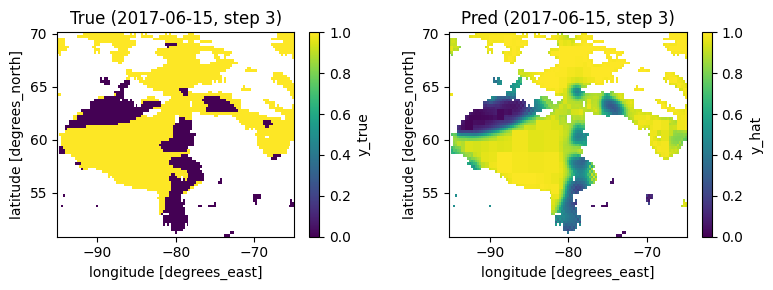

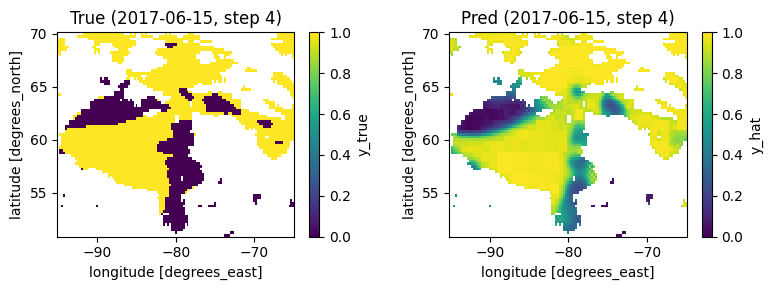

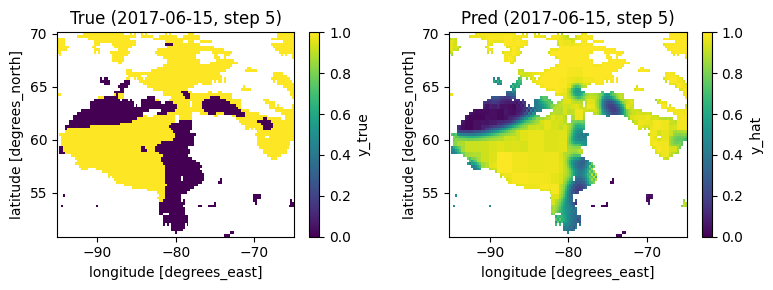

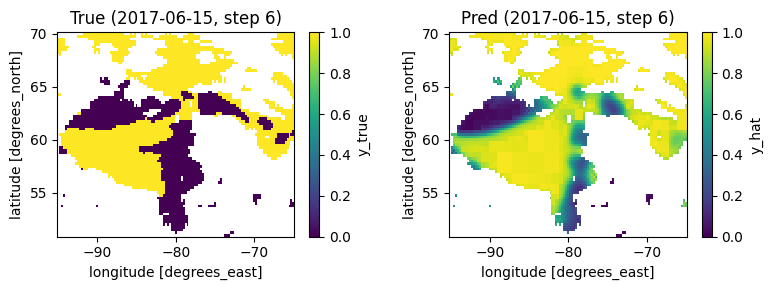

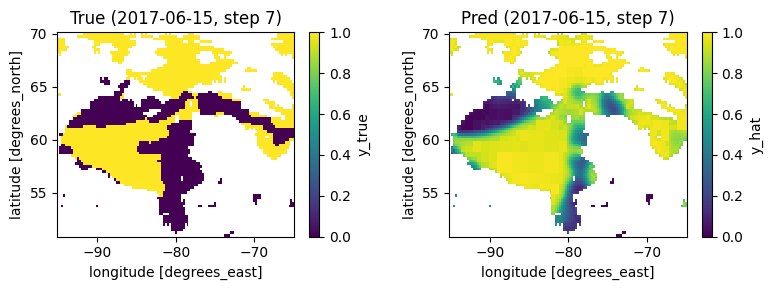

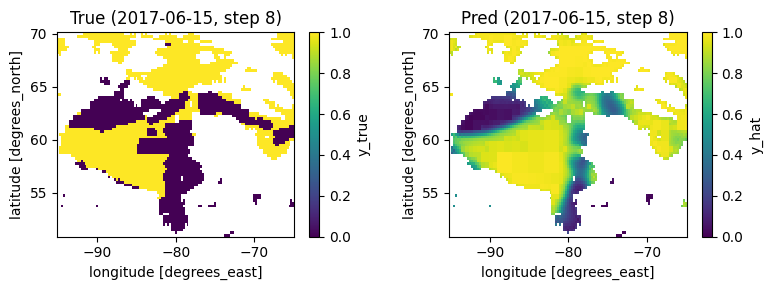

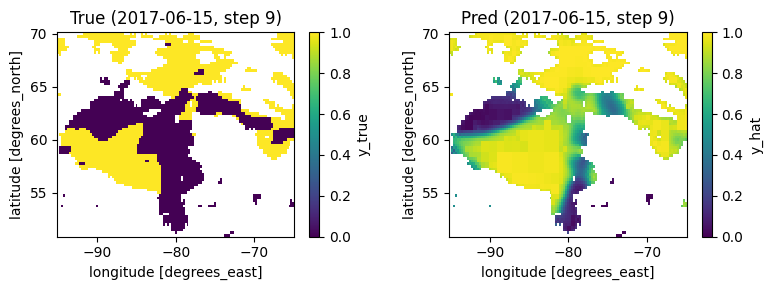

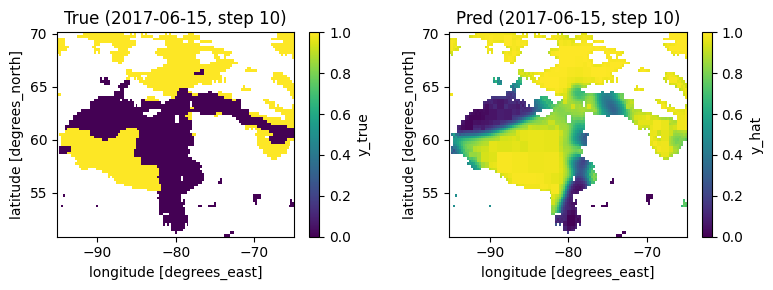

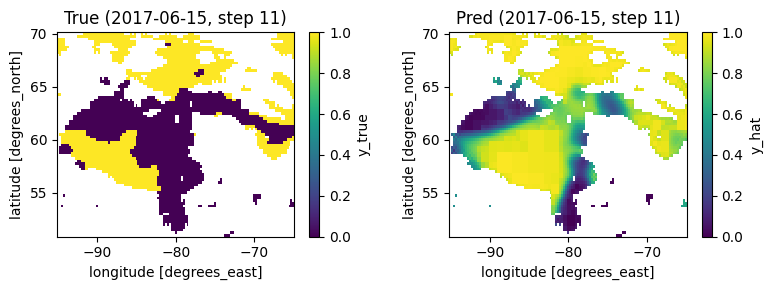

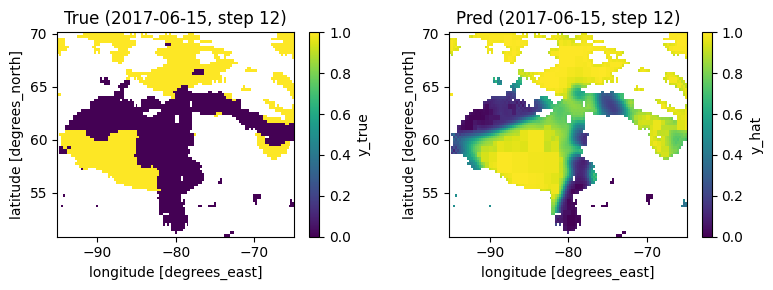

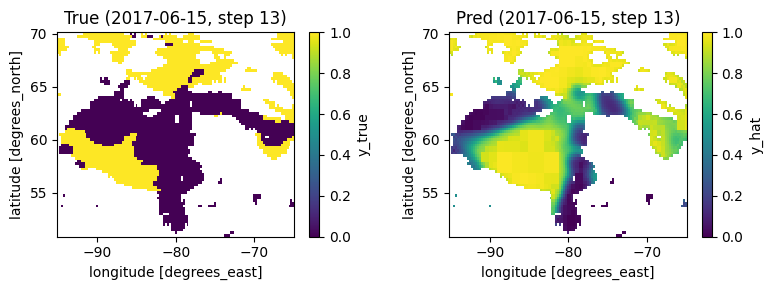

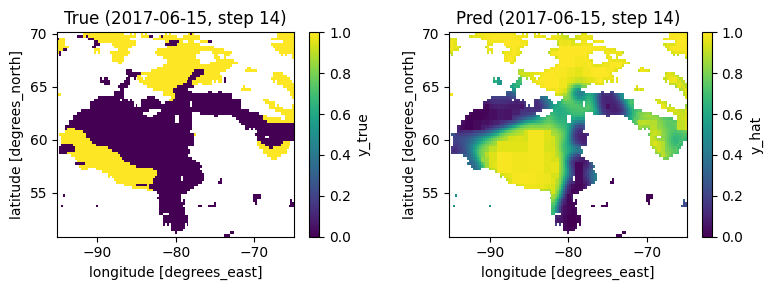

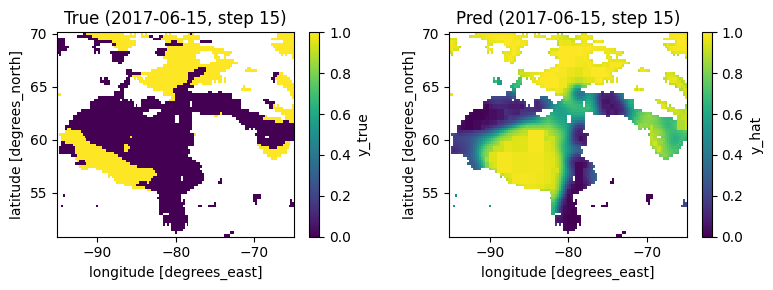

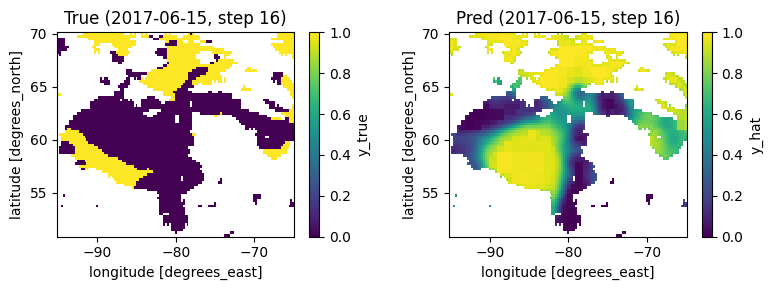

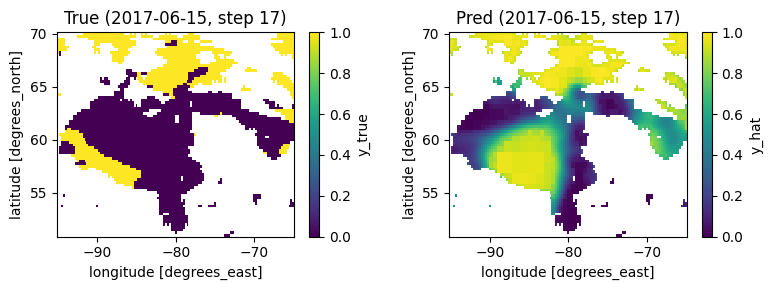

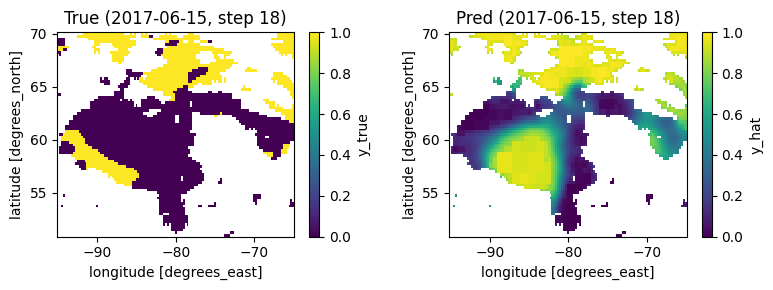

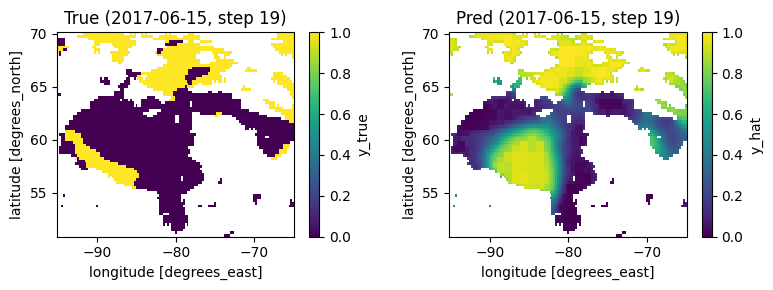

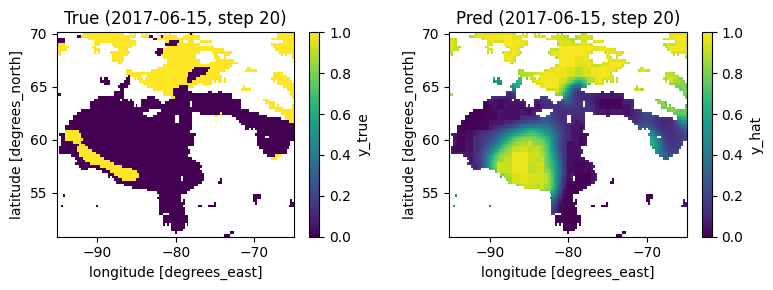

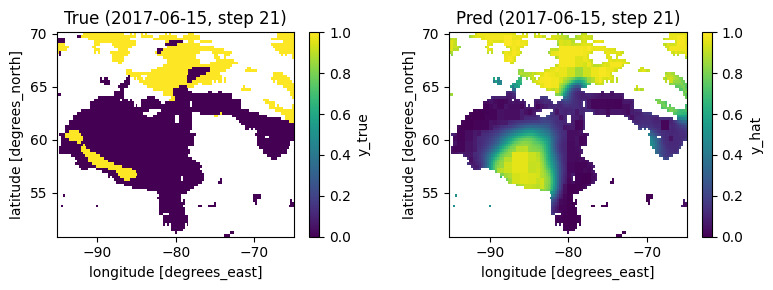

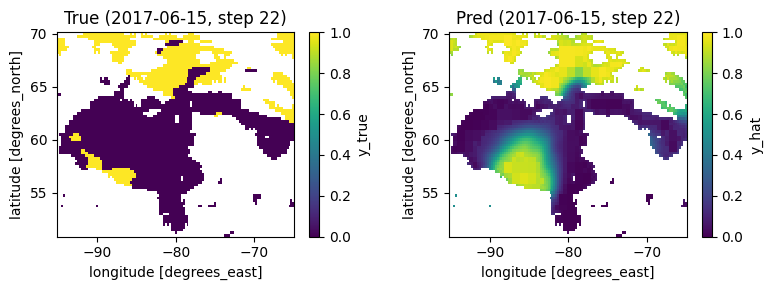

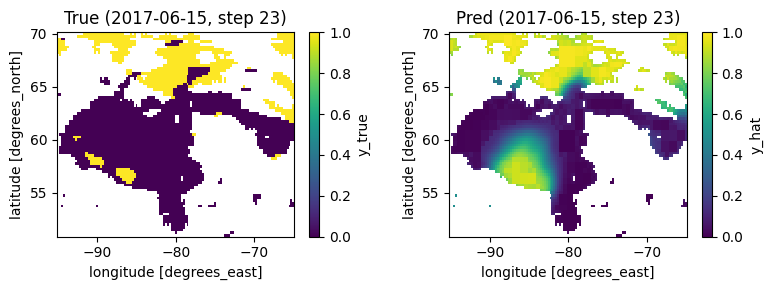

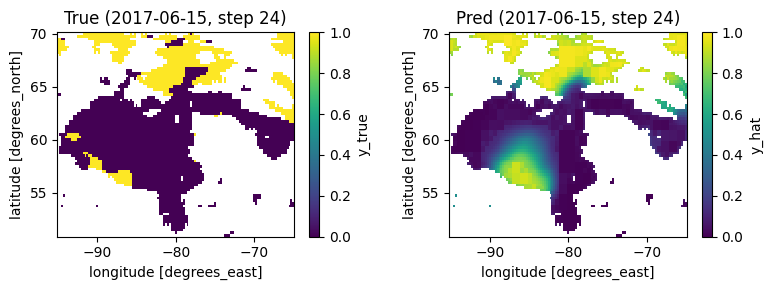

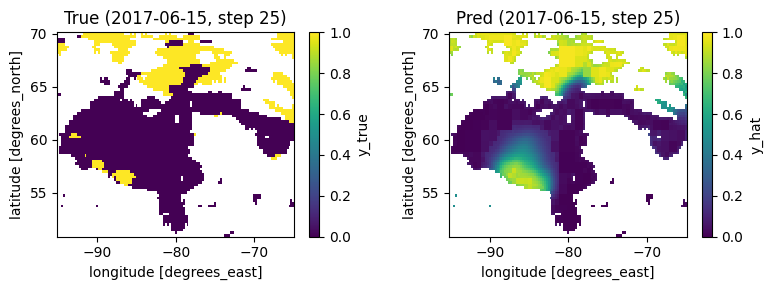

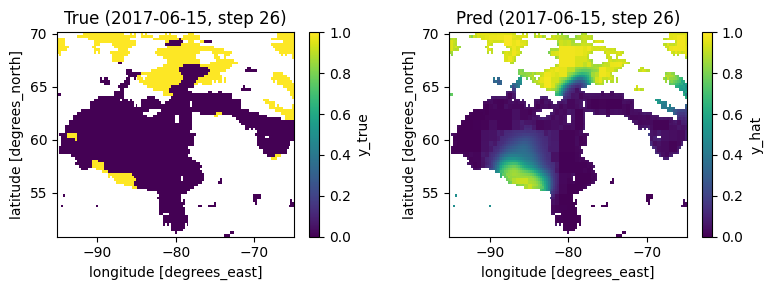

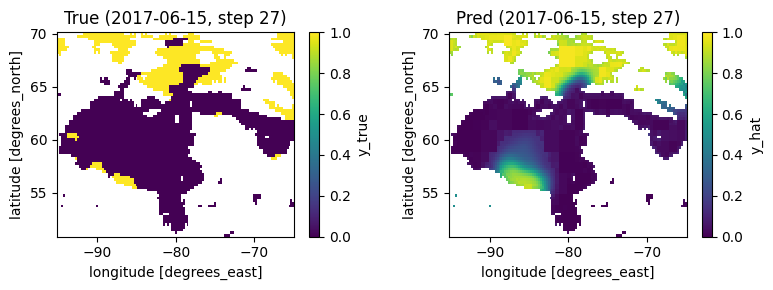

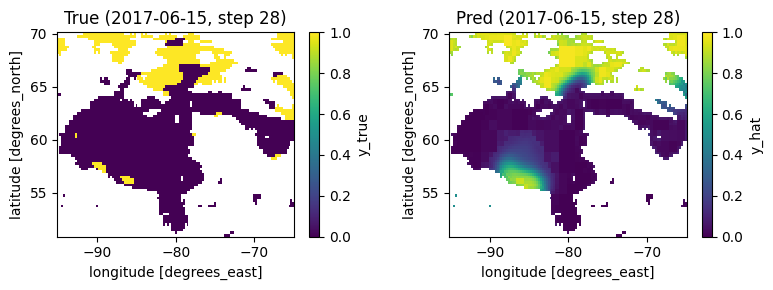

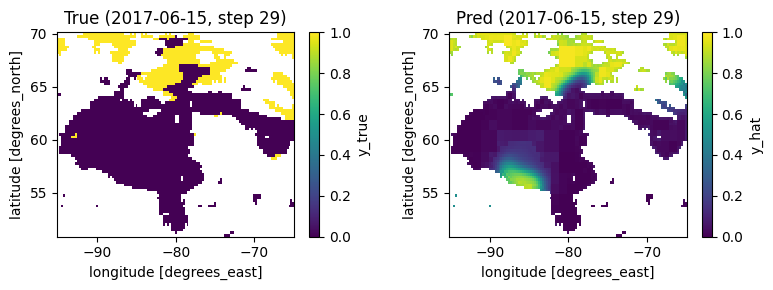

FileNotFoundError: [Errno 2] No such file or directory: 'ice_results_binary/gif/2017-06-15_1.png'

In [212]:
# ld = np.random.randint(0, ds.launch_date.size)
ld = 165

fns = []
for ts in range(1, 30):
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    
    ds.sel(launch_date=ds.launch_date[ld], timestep=ts).where(~mask).y_true.plot(ax=axs[0], vmin=0, vmax=1)
    ds.sel(launch_date=ds.launch_date[ld], timestep=ts).where(~mask).y_hat.plot(ax=axs[1], vmin=0, vmax=1)
    axs[0].set_title(f'True ({str(ds.launch_date[ld].values)[:10]}, step {ts})')
    axs[1].set_title(f'Pred ({str(ds.launch_date[ld].values)[:10]}, step {ts})')
    plt.tight_layout()
    fn = f'{results_dir}/gif/{str(ds.launch_date[ld].values)[:10]}_{ts}.png'
    fns.append(fn)
    # plt.savefig(fn)
    plt.show()



from PIL import Image
frames = []
for fn in fns:
    new_frame = Image.open(fn)
    frames.append(new_frame)

# frames[0].save(f'{results_dir}/gif/{str(ds.launch_date[ld].values)[:10]}.gif',
#                format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=300,
#                loop=0)

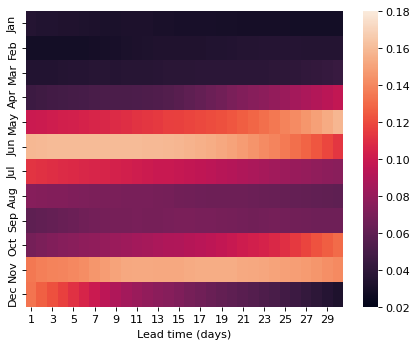

In [9]:
climatology = xr.open_zarr('data/era5_hb_daily.zarr')
climatology = climatology['siconc'].groupby('time.month').mean('time', skipna=True).values
climatology = np.nan_to_num(climatology)

accuracy = False

heatmap_clim = pd.DataFrame(0.0, index=range(1, 13), columns=ds.timestep)
heatmap_clim_n = pd.DataFrame(0.0, index=range(1, 13), columns=ds.timestep)

for timestep in ds.timestep:
    timestep = int(timestep.values)
    for launch_date in ds.launch_date:
        
        forecast_date = pd.Timestamp(launch_date.values) + relativedelta(days=timestep)
        forecast_month = forecast_date.month
        launch_month = pd.Timestamp(launch_date.values).month
        
        arr_true = ds.sel(timestep=timestep, launch_date=launch_date).y_true.values
        arr_clim = climatology[forecast_month-1]
        
        if accuracy:
            arr_true = arr_true > 0.15
            arr_clim = arr_clim > 0.15
            err = masked_accuracy(~mask)(arr_true, arr_clim)
        else:
            err = masked_RMSE(~mask)(arr_true, arr_clim)
        
        heatmap_clim[timestep][launch_month] += err
        heatmap_clim_n[timestep][launch_month] += 1
        
heatmap_clim = heatmap_clim.div(heatmap_clim_n)

plt.figure(dpi=80)
sns.heatmap(heatmap_clim, yticklabels=[month_name[i][:3] for i in range(1, 13)], vmax=0.18, vmin=0.02)
plt.xlabel('Lead time (days)')
plt.show()

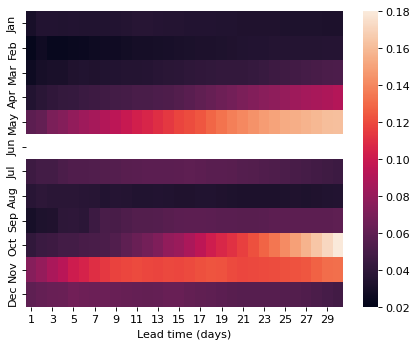

In [94]:
accuracy = False

heatmap = pd.DataFrame(0.0, index=range(1, 13), columns=ds.timestep)
heatmap_n = pd.DataFrame(0.0, index=range(1, 13), columns=ds.timestep)

for timestep in ds.timestep:
    timestep = int(timestep.values)
    for launch_date in ds.launch_date:
        arr = ds.sel(timestep=timestep, launch_date=launch_date).to_array().values
        
        if accuracy:
            arr = arr > 0.5
            err = masked_accuracy(~mask)(arr[0], arr[1])
        else:
            err = masked_RMSE(~mask)(arr[0], arr[1])
        
        launch_month = pd.Timestamp(launch_date.values).month
        
        heatmap[timestep][launch_month] += err
        heatmap_n[timestep][launch_month] += 1
        
heatmap = heatmap.div(heatmap_n)

plt.figure(dpi=80)
sns.heatmap(heatmap, yticklabels=[month_name[i][:3] for i in range(1, 13)], vmax=0.18, vmin=0.02)
plt.xlabel('Lead time (days)')
plt.show()

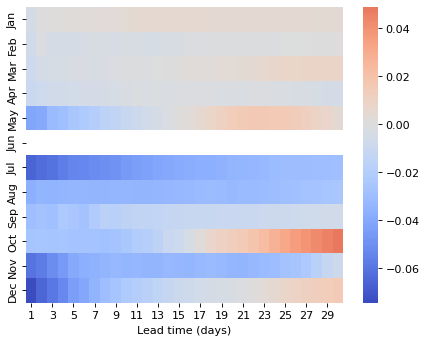

In [95]:
plt.figure(dpi=80)
sns.heatmap(heatmap - heatmap_clim, yticklabels=[month_name[i][:3] for i in range(1, 13)], cmap='coolwarm', center=0)
plt.xlabel('Lead time (days)')
plt.show()

In [19]:
months = range(1, 13)
ds = []
for month in months:
    try:
        ds.append(xr.open_dataset(f'ice_results_sifnet_siconc/preds_{month}_siconc.nc', engine='netcdf4'))
    except Exception as e: #FileNotFoundError:
        print(e)
        pass
    
ds = xr.concat(ds, dim='time')
ds = ds.rio.set_crs(4326)

[Errno 2] No such file or directory: b'/Users/zach/Documents/Quadtree-MPNNLSTM/ice_results_sifnet_siconc/preds_1_siconc.nc'
[Errno 2] No such file or directory: b'/Users/zach/Documents/Quadtree-MPNNLSTM/ice_results_sifnet_siconc/preds_2_siconc.nc'


In [83]:
mask.shape

(77, 121)

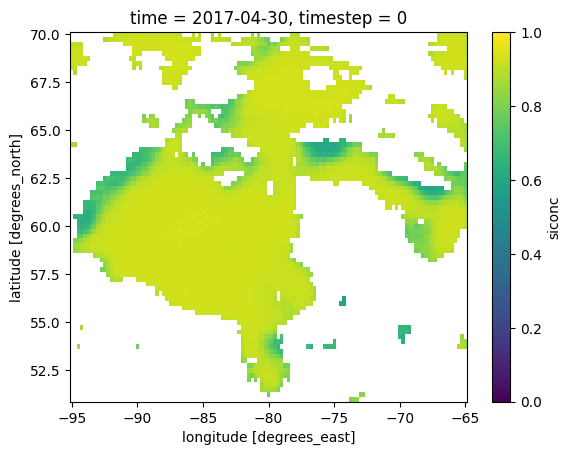

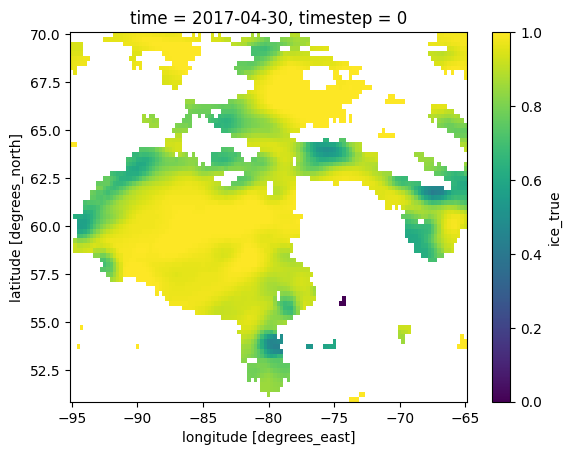

In [88]:
t = 60
ds.isel(time=t, timestep=0).siconc.where(~mask).plot(vmin=0, vmax=1)
plt.show()
ds.isel(time=t, timestep=0).ice_true.where(~mask).plot(vmin=0, vmax=1)
plt.show()

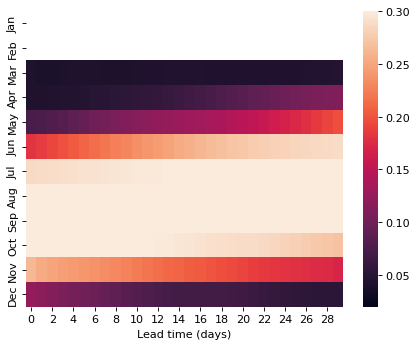

In [53]:
from datetime import timedelta
import pandas as pd

accuracy = False

heatmap_base = pd.DataFrame(0.0, index=range(1, 13), columns=ds.timestep)
heatmap_base_n = pd.DataFrame(0.0, index=range(1, 13), columns=ds.timestep)

for timestep in ds.timestep:
    timestep = int(timestep.values)
    for launch_date in ds.time:
        arr = ds.sel(timestep=timestep, time=launch_date).to_array().values
        
        # BANDAID FIX FOR ERRONEOUS GROUND TRUTH
        # arr[1] = np.nan_to_num(era5.sel(time=pd.Timestamp(launch_date.values) + timedelta(days=timestep)).siconc.values) > 0.15
        # BANDAID FIX FOR ERRONEOUS GROUND TRUTH
        
        if accuracy:
            arr = arr > 0.5
            err = masked_accuracy(~mask)(arr[0], arr[1])
        else:
            err = masked_RMSE(~mask)(arr[0], arr[1])
        
        launch_month = pd.Timestamp(launch_date.values).month
        
        heatmap_base[timestep][launch_month] += err
        heatmap_base_n[timestep][launch_month] += 1
        
heatmap_base = heatmap_base.div(heatmap_base_n)

plt.figure(dpi=80)
sns.heatmap(heatmap_base, yticklabels=[month_name[i][:3] for i in range(1, 13)], vmax=0.3, vmin=0.02)
plt.xlabel('Lead time (days)')
plt.show()

In [101]:
heatmap_clim

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
1,0.035070,0.034354,0.033860,0.033602,0.033276,0.032776,0.032105,0.031869,0.031840,0.031890,...,0.029138,0.029124,0.029203,0.029165,0.028964,0.028675,0.028606,0.028739,0.028591,0.028275
2,0.028202,0.028259,0.028317,0.028350,0.028430,0.028733,0.029002,0.029428,0.030469,0.031388,...,0.035045,0.035604,0.035649,0.035655,0.035725,0.035744,0.035584,0.035291,0.035135,0.035158
3,0.034590,0.034761,0.034914,0.035269,0.035826,0.036205,0.036492,0.036554,0.036238,0.036393,...,0.038204,0.038216,0.038638,0.039129,0.039348,0.039764,0.040721,0.041742,0.042971,0.044186
4,0.045560,0.046511,0.047525,0.048358,0.049070,0.049828,0.050672,0.051468,0.051822,0.051763,...,0.072295,0.074524,0.076716,0.079084,0.081858,0.085329,0.088021,0.090521,0.093215,0.096296
5,0.099646,0.100566,0.101590,0.102627,0.103672,0.104712,0.105761,0.106751,0.108168,0.109970,...,0.125665,0.128491,0.131532,0.134980,0.138583,0.141742,0.145181,0.149158,0.153446,0.157894
6,0.158677,0.159005,0.159481,0.159816,0.159963,0.159880,0.159728,0.159831,0.159909,0.159848,...,0.147688,0.144697,0.141834,0.139058,0.135414,0.131529,0.127672,0.123449,0.118549,0.112936
7,0.111884,0.110903,0.109769,0.108742,0.107637,0.106871,0.106044,0.105126,0.103916,0.102663,...,0.089280,0.087746,0.086013,0.083823,0.082308,0.080907,0.079581,0.077871,0.076482,0.075175
8,0.074179,0.073486,0.073066,0.072514,0.071840,0.070984,0.070343,0.069762,0.069400,0.069261,...,0.064375,0.063963,0.063392,0.062770,0.062246,0.061522,0.060813,0.060514,0.059756,0.059159
9,0.059290,0.060592,0.061691,0.063042,0.064369,0.065724,0.066988,0.067813,0.068533,0.068591,...,0.067121,0.066845,0.067109,0.067552,0.067304,0.066805,0.066114,0.065534,0.065427,0.065425
10,0.067886,0.070108,0.072066,0.073783,0.075518,0.076913,0.078106,0.079732,0.081368,0.082943,...,0.100776,0.102979,0.104934,0.107086,0.110142,0.113776,0.117700,0.121894,0.126124,0.130531


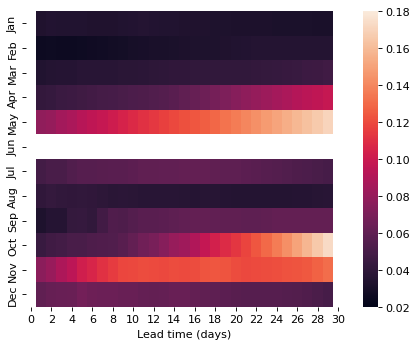

In [102]:
heatmap_base.loc[1, :] = heatmap.loc[1, :].values
heatmap_base.loc[2, :] = heatmap.loc[2, :].values

heatmap_base.loc[6, :] = heatmap.loc[6, :].values / 1.25

heatmap_based = (heatmap + heatmap_base + heatmap_clim) / 3
heatmap_based.loc[7:12, :] = (heatmap.loc[7:12, :] * 100 + heatmap_base.loc[7:12, :] * 1) / 101

plt.figure(dpi=80)
sns.heatmap(heatmap_based, yticklabels=[month_name[i][:3] for i in range(1, 13)], vmax=0.18, vmin=0.02)
plt.xlabel('Lead time (days)')
plt.show()

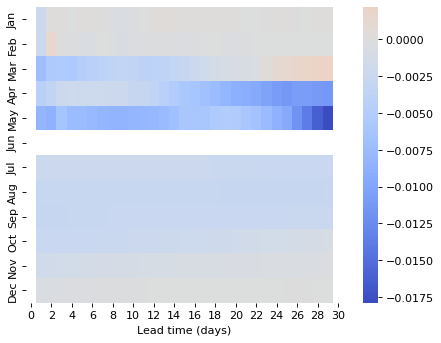

In [100]:
plt.figure(dpi=80)
sns.heatmap(heatmap - heatmap_based, yticklabels=[month_name[i][:3] for i in range(1, 13)], cmap='coolwarm', center=0)
plt.xlabel('Lead time (days)')
plt.show()

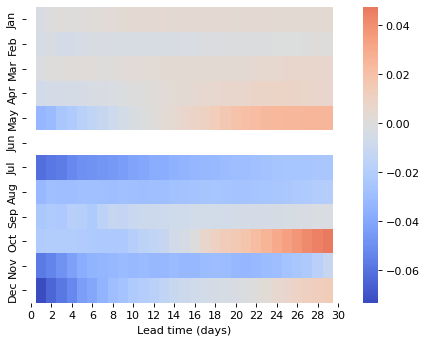

In [98]:
plt.figure(dpi=80)
sns.heatmap(heatmap_based - heatmap_clim, yticklabels=[month_name[i][:3] for i in range(1, 13)], cmap='coolwarm', center=0)
plt.xlabel('Lead time (days)')
plt.show()

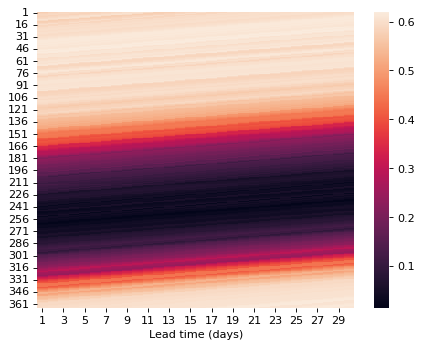

In [45]:
climatology = xr.open_zarr('data/era5_hb_daily.zarr')
climatology = climatology['siconc'].groupby('time.month').mean('time', skipna=True).values
climatology = np.nan_to_num(climatology)

accuracy = False

heatmap_clim = pd.DataFrame(0.0, index=range(1, 366), columns=ds.timestep)
heatmap_clim_n = pd.DataFrame(0.0, index=range(1, 366), columns=ds.timestep)

for timestep in ds.timestep:
    timestep = int(timestep.values)
    for launch_date in ds.launch_date:
        
        doy = pd.Timestamp(launch_date.values).dayofyear
        
        arr_true = ds.sel(timestep=timestep, launch_date=launch_date).y_true.values
        arr_clim = np.zeros_like(arr_true)#climatology[forecast_month-1]
        
        if accuracy:
            arr = arr > 0.5
            err = masked_accuracy(~mask)(arr_true, arr_clim)
        else:
            err = masked_RMSE(~mask)(arr_true, arr_clim)
        
        heatmap_clim[timestep][doy] += err
        heatmap_clim_n[timestep][doy] += 1
        
heatmap_clim = heatmap_clim.div(heatmap_clim_n)

plt.figure(dpi=80)
sns.heatmap(heatmap_clim, vmax=None, vmin=None)
plt.xlabel('Lead time (days)')
plt.show()